In [1]:
from kmer_feature_matrix_pipeline_funcs import *
from filtering_functions import *

df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', sep='\t')
df = pd.DataFrame(df)

df_preprocessed = preprocess_data(df)
df_preprocessed_species = filter_by_species(df_preprocessed)
df_preprocessed_species_min_score = filter_by_minimum_score(df_preprocessed_species)
df_filtered_epitope = filter_by_length_range(df_preprocessed_species_min_score, 'antigen.epitope')
df_done = filter_by_mhc_class(df_preprocessed_species_min_score)

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_90444/1022910231.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', sep='\t')
/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/filtering_functions.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '.length'] = df[column_name].apply(len)


In [3]:

# Assuming 'df' is your original DataFrame
min_instances = 5 # Set the minimum number of instances required for inclusion
filtered_df = filter_by_epitope_instances(df_done, label_col='antigen.epitope', min_instances=min_instances)

print(f"Original DataFrame had {len(df_done)} rows.")
print(f"Filtered DataFrame has {len(filtered_df)} rows.")
print(f"unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].value_counts()}")
print(f"Number of unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].nunique()}")

Original DataFrame had 1385 rows.
Filtered DataFrame has 1058 rows.
unique epitopes in the filtered DataFrame: NLVPMVATV        301
GILGFVFTL        185
GLCTLVAML         61
YLQPRTFLL         58
QYIKWPWYI         51
RPRGEVRFL         44
KLVALGINAV        39
ELAGIGILTV        22
SPRWYFYYL         21
CINGVCWTV         21
DATYQRTRALVR      20
VAANIVLTV         15
EAAGIGILTV        15
EPLPQGQLTAY       15
CVNGSCFTV         14
TAFTIPSI          14
RLPGVLPRA         13
HPVGEADYFEY       11
HMTEVVRHC         11
RLITGRLQSL        10
TLWCSPIKV         10
TPRVTGGGAM         9
LPEPLPQGQLTAY      9
GPRLGVRAT          8
VVMSWAPPV          8
NYNYLYRLF          7
RLARLALVL          7
GADGVGKSAL         7
APRGPHGGAASGL      7
AAGIGILTV          7
FLRGRAYGL          6
SLLMWITQV          6
ALYGFVPVL          6
KLVAMGINAV         5
AAFKRSCLK          5
LLFGYPVYV          5
KLSALGINAV         5
Name: antigen.epitope, dtype: int64
Number of unique epitopes in the filtered DataFrame: 37


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(filtered_df, include_alpha=False, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=200, learning_rate=0.01, max_features='sqrt', max_depth=7)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
auc_dict, acc_list, precision_list, recall_list, all_class_reports, all_conf_matrices, clf = predict_auc(X, y, rf_classifier, 5, epitope_names, True)


ValueError: not enough values to unpack (expected 6, got 5)

In [18]:
import pandas as pd



# Create DataFrame
columns = ['Fold'] + epitope_names + ['Micro Average', 'Macro Average']  # Include epitope names and averages
data = []

# Loop over each fold in auc_dict
for fold, scores in auc_dict.items():
    row = [f"Fold {fold}"]  # Start with fold number
    row += [scores.get(epi) for epi in range(len(epitope_names))]  # Append AUC score for each epitope
    row += [scores.get('micro'), scores.get('macro')]  # Append micro and macro AUC scores
    data.append(row)

results_df = pd.DataFrame(data, columns=columns)

# Calculate and append the mean values for each epitope and averages across all folds
mean_scores = ['Average'] + [results_df[epi].mean() for epi in epitope_names] + [results_df['Micro Average'].mean(), results_df['Macro Average'].mean()]
results_df.loc[len(results_df)] = mean_scores  # Add mean scores as the last row

# Display the DataFrame
results_df




,Fold,ELAGIGILTV,LLFGYPVYV,FLRGRAYGL,GILGFVFTL,LPEPLPQGQLTAY,SLLMWITQV,EPLPQGQLTAY,NLVPMVATV,HPVGEADYFEY,...,VAANIVLTV,TPRVTGGGAM,TLWCSPIKV,DATYQRTRALVR,RLPGVLPRA,KLSALGINAV,SPRWYFYYL,NYNYLYRLF,Micro Average,Macro Average
0,Fold 1,0.515459,1.0,1.000000,0.916525,1.000000,0.796209,1.000000,0.816886,1.000000,...,0.437799,0.846429,0.772619,0.632212,0.766667,0.838863,0.471014,0.997630,0.891594,0.756053
1,Fold 2,0.542512,1.0,1.000000,0.883784,1.000000,0.722749,0.737640,0.785855,0.673810,...,0.820574,0.766667,0.903571,0.445913,0.483333,0.300948,0.822115,0.811905,0.880422,0.728252
2,Fold 3,0.840745,1.0,1.000000,0.904402,0.317536,0.333333,0.992823,0.759649,0.971429,...,0.578947,1.000000,0.742857,0.596154,0.692185,0.367299,0.612981,0.984524,0.879256,0.713191
3,Fold 4,0.401570,1.0,0.352381,0.827120,0.659091,0.350000,0.612981,0.791913,1.000000,...,0.294872,0.959330,0.510766,0.809179,0.454327,0.316667,0.724034,0.269048,0.856458,0.621079
4,Fold 5,0.490338,1.0,0.340476,0.867195,1.000000,0.307143,0.838942,0.762252,0.736378,...,0.658654,0.954545,0.711722,0.521135,0.637019,0.321429,0.439614,1.000000,0.877917,0.705369
5,Average,0.558125,1.0,0.738571,0.879805,0.795325,0.501887,0.836477,0.783311,0.876323,...,0.558169,0.905394,0.728307,0.600919,0.606706,0.429041,0.613952,0.812621,0.877129,0.704789


In [19]:
import pandas as pd
unique_epitope_count = filtered_df['antigen.epitope'].value_counts().to_dict()
# Assuming 'results_df' is your DataFrame with the average AUC scores for each epitope and 'unique_epitope_count' is a dictionary with epitope counts.
# Convert the dictionary to a DataFrame
epitope_counts_df = pd.DataFrame(list(unique_epitope_count.items()), columns=['Epitope', 'Count'])

# Extract the average AUC scores for each epitope from results_df
average_auc_scores = results_df.iloc[-1, 1:-2]  # Exclude 'Fold', 'Micro Average', and 'Macro Average' columns
average_auc_scores = pd.DataFrame(average_auc_scores).reset_index()
average_auc_scores.columns = ['Epitope', 'Average AUC']

# Merge the AUC scores with the counts
combined_df = pd.merge(average_auc_scores, epitope_counts_df, on='Epitope')


In [21]:
# Check data types
print(combined_df.dtypes)

# Convert 'Count' and 'Average AUC' to numeric if they are not
combined_df['Count'] = pd.to_numeric(combined_df['Count'], errors='coerce')
combined_df['Average AUC'] = pd.to_numeric(combined_df['Average AUC'], errors='coerce')

# Calculate correlation again
correlation = combined_df['Count'].corr(combined_df['Average AUC'])
print(f"Correlation between epitope count and AUC score: {correlation}")




Epitope        object
Average AUC    object
Count           int64
dtype: object
Correlation between epitope count and AUC score: 0.21692161758773082


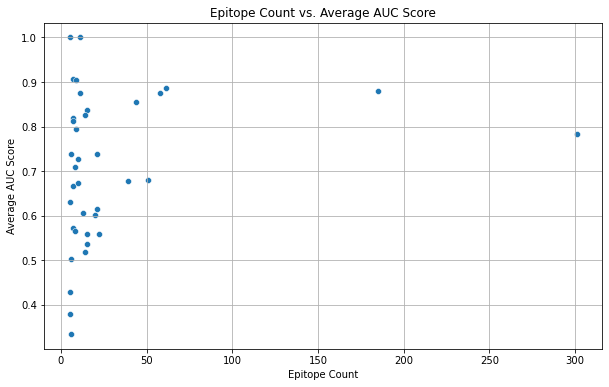

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Count', y='Average AUC', data=combined_df)
plt.title('Epitope Count vs. Average AUC Score')
plt.xlabel('Epitope Count')
plt.ylabel('Average AUC Score')
plt.grid(True)
plt.show()


In [24]:
# Define high and low thresholds
high_threshold = 0.8
low_threshold = 0.4

# Extract the 'Average' row for the epitopes
average_auc_scores = results_df.iloc[-1, 1:-2]  # This excludes 'Fold', 'Micro Average', 'Macro Average'

# Find high and low performing epitopes
high_performers = average_auc_scores[average_auc_scores > high_threshold].index.tolist()
low_performers = average_auc_scores[average_auc_scores < low_threshold].index.tolist()

